## Data Loading and Preprocessing

In [5]:

import os
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import monotonically_increasing_id

def load_data(base_dir):
    # File paths
    triplets_filename = os.path.join(base_dir, 'train_triplets.txt')
    songs2tracks_filename = os.path.join(base_dir, 'taste_profile_song_to_tracks.txt')
    metadata_filename = os.path.join(base_dir, 'track_metadata.csv')

    # Schema defs
    plays_df_schema = StructType([StructField('userId', StringType()), StructField('songId', StringType()), StructField('Plays', IntegerType())])
    songs2tracks_df_schema = StructType([StructField('songId', StringType()), StructField('trackId', StringType())])
    metadata_df_schema = StructType(
  [StructField('trackId', StringType()),
   StructField('title', StringType()),
   StructField('songId', StringType()),
   StructField('release', StringType()),
   StructField('artist_id', StringType()),
   StructField('artist_mbid', StringType()),
   StructField('artist_name', StringType()),
   StructField('duration', DoubleType()),
   StructField('artist_familiarity', DoubleType()),
   StructField('artist_hotttness', DoubleType()),
   StructField('year', IntegerType()),
   StructField('track_7digitalid', IntegerType()),
   StructField('shs_perf', DoubleType()),
   StructField('shs_work', DoubleType())]
)



    spark = SparkSession.builder.appName("MusicRec").getOrCreate()

    # Loading data
    raw_plays_df = spark.read.format('com.databricks.spark.csv').options(delimiter='\t', header=False, inferSchema=False).schema(plays_df_schema).load(triplets_filename)
    print(f"Loaded raw plays data from {triplets_filename}")

    songs2tracks_df = spark.read.format('com.databricks.spark.csv').options(delimiter='\t', header=False, inferSchema=False).schema(songs2tracks_df_schema).load(songs2tracks_filename)
    print(f"Loaded song to tracks data from {songs2tracks_filename}")

    metadata_df = spark.read.format('com.databricks.spark.csv').options(delimiter=',', header=False, inferSchema=False).schema(metadata_df_schema).load(metadata_filename)
    print(f"Loaded metadata from {metadata_filename}")
    
    return raw_plays_df, songs2tracks_df, metadata_df


    

if __name__ == '__main__':
    base_dir = './MSD'
    raw_plays_df, songs2tracks_df, metadata_df = load_data(base_dir)
    print("All data successfully loaded from directory:", base_dir)

Loaded raw plays data from ./MSD/train_triplets.txt
Loaded song to tracks data from ./MSD/taste_profile_song_to_tracks.txt
Loaded metadata from ./MSD/track_metadata.csv
All data successfully loaded from directory: ./MSD


In [6]:
def prepare_transformed_data(raw_plays_df):
    userId_change = raw_plays_df.select('userId').distinct().select('userId', F.monotonically_increasing_id().alias('new_userId'))
    songId_change = raw_plays_df.select('songId').distinct().select('songId', F.monotonically_increasing_id().alias('new_songId'))
    
    unique_users = userId_change.count()
    unique_songs = songId_change.count()
    
    raw_plays_df_with_int_ids = raw_plays_df.join(userId_change, 'userId').join(songId_change, 'songId')
    raw_plays_df_with_int_ids = raw_plays_df_with_int_ids.filter(raw_plays_df_with_int_ids.new_userId < unique_users/2)

    # Cache the transformed DataFrame
    raw_plays_df_with_int_ids.cache()

    return raw_plays_df_with_int_ids

# Data Analysis and Visualization

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

raw_plays_df_with_int_ids = prepare_transformed_data(raw_plays_df)


23/11/29 10:40:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
/var/folders/fk/b7dd25t91rq06z3l8zsn15r00000gn/T/ipykernel_61636/2904824722.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colorMap)


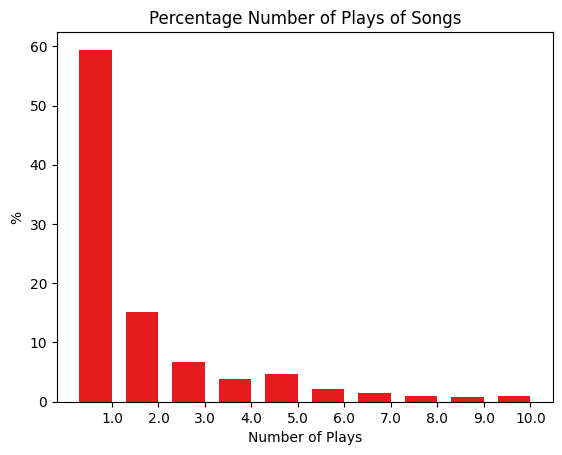

In [8]:

# Count total entries
total_entries = raw_plays_df_with_int_ids.count()

# Find percentage listens by number of songs played
number_listens = []
for i in range(10):
    number_listens.append(float(raw_plays_df_with_int_ids.filter(raw_plays_df_with_int_ids.Plays == i+1).count())/total_entries*100)

# create plot
bar_width = 0.7
colorMap = 'Set1'
cmap = cm.get_cmap(colorMap)

fig, ax = plt.subplots()
ax.bar(np.linspace(1, 10, 10), number_listens, width=bar_width, color=cmap(0))
ax.set_xticks(np.linspace(1, 10, 10) + bar_width/2.0)
ax.set_xticklabels(np.linspace(1, 10, 10))
ax.set_xlabel('Number of Plays')
ax.set_ylabel('%')
ax.set_title('Percentage Number of Plays of Songs')

plt.show()

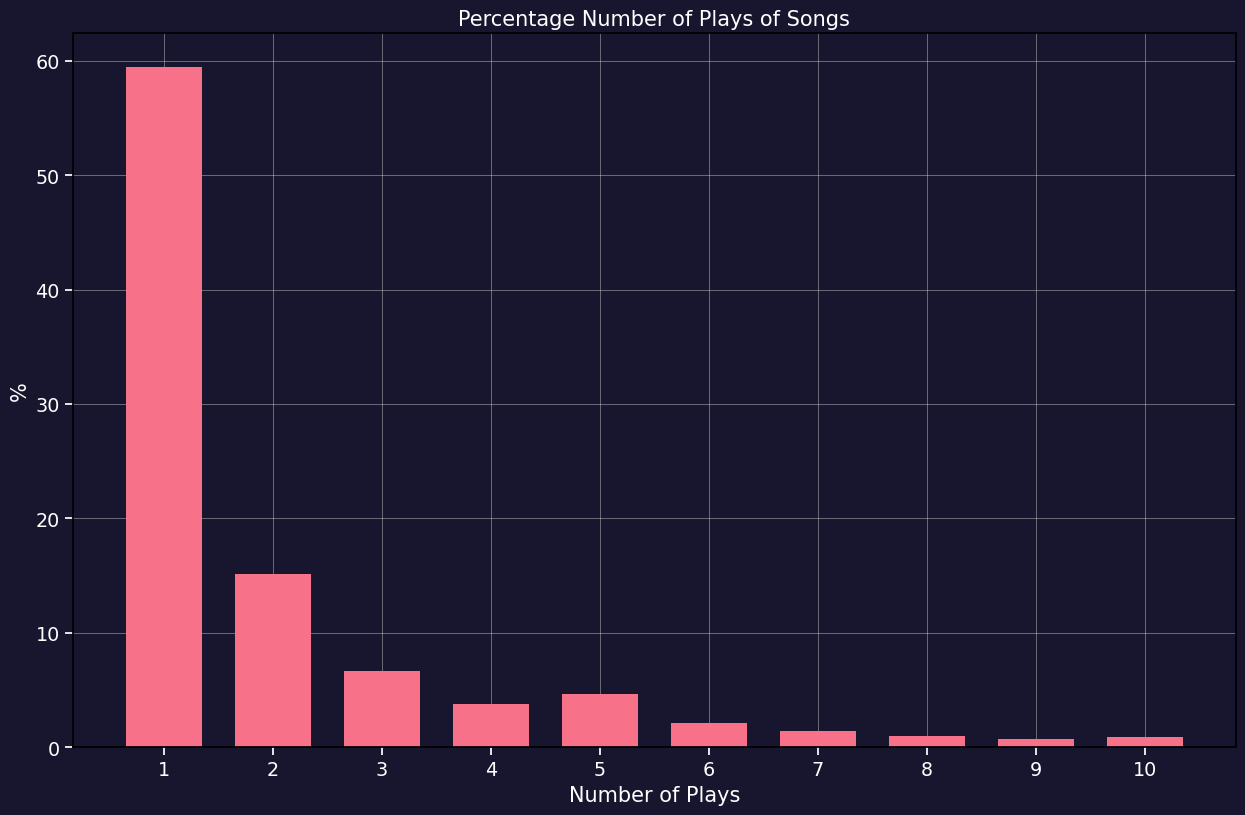

23/11/29 18:04:01 WARN TransportChannelHandler: Exception in connection from /192.168.4.28:60167
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:276)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:233)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:223)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:356)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOpti

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

# Set the color and style
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_palette("husl")

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15/1.6180))

# Plotting
ax.bar(np.arange(10), number_listens, width=0.7)

# Set ticks and labels
ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(1, 11))

# Styling the plot (colors, labels, and title)
ax.set_xlabel('Number of Plays', color='white')
ax.set_ylabel('%', color='white')
ax.set_title('Percentage Number of Plays of Songs', color='white')
ax.tick_params(colors='white')

# Set background color
ax.set_facecolor('#17162e')
fig.set_facecolor('#17162e')

ax.grid(True, color='white', linestyle='-', linewidth=0.5, alpha=0.5)  # Adjust alpha for transparency
ax.set_axisbelow(True) 

# Show the plot
plt.show()


## Data Preparation for ALS

In [9]:
# We'll hold out 60% for training, 20% of our data for validation, and leave 20% for testing
seed = 42
(split_60_df, split_a_20_df, split_b_20_df) = raw_plays_df_with_int_ids.randomSplit([0.6, 0.2, 0.2], seed = seed)

# Let's cache these datasets for performance
training_df = split_60_df.cache()
validation_df = split_a_20_df.cache()
test_df = split_b_20_df.cache()

print('Training: {0}, validation: {1}, test: {2}\n'.format(
  training_df.count(), validation_df.count(), test_df.count())
)
training_df.show(3)
validation_df.show(3)
test_df.show(3)

#Number of plays needs to be double type, not integers
validation_df = validation_df.withColumn("Plays", validation_df["Plays"].cast(DoubleType()))

from pyspark.sql.functions import col

training_df = training_df.withColumn("new_songId", col("new_songId").cast("integer"))
training_df = training_df.withColumn("new_userId", col("new_userId").cast("integer"))
validation_df = validation_df.withColumn("new_songId", col("new_songId").cast("integer"))
validation_df = validation_df.withColumn("new_userId", col("new_userId").cast("integer"))
test_df = test_df.withColumn("new_songId", col("new_songId").cast("integer"))
test_df = test_df.withColumn("new_userId", col("new_userId").cast("integer"))

Training: 1742149, validation: 580227, test: 579449

+------------------+--------------------+-----+----------+----------+
|            songId|              userId|Plays|new_userId|new_songId|
+------------------+--------------------+-----+----------+----------+
|SOAAAGQ12A8C1420C8|05a6529cf2d2ef2cd...|    1|     43809|     15709|
|SOAAAGQ12A8C1420C8|08ea2b0d566996ed1...|    1|     56791|     15709|
|SOAAAGQ12A8C1420C8|10b4f04d763f0b0a3...|    1|     11475|     15709|
+------------------+--------------------+-----+----------+----------+
only showing top 3 rows

+------------------+--------------------+-----+----------+----------+
|            songId|              userId|Plays|new_userId|new_songId|
+------------------+--------------------+-----+----------+----------+
|SOAAAGQ12A8C1420C8|01845f57f5c8b3309...|    2|      4510|     15709|
|SOAAAGQ12A8C1420C8|0d15c552c704487af...|    5|     47569|     15709|
|SOAAAGQ12A8C1420C8|382a6119435d4f94b...|    2|     52385|     15709|
+-----------

## ALS Model

In [10]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Let's initialize our ALS learner
als = ALS()

# Now set the parameters for the method
als.setMaxIter(5)\
   .setSeed(seed)\
   .setItemCol("new_songId")\
   .setRatingCol("Plays")\
   .setUserCol("new_userId")

# Now let's compute an evaluation metric for our test dataset
# We Create an RMSE evaluator using the label and predicted columns
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="Plays", metricName="rmse")

tolerance = 0.03
ranks = [4, 8, 12, 16]
regParams = [0.15, 0.2, 0.25]
errors = [[0]*len(ranks)]*len(regParams)
models = [[0]*len(ranks)]*len(regParams)
err = 0
min_error = float('inf')
best_rank = -1
i = 0
for regParam in regParams:
    j = 0
    for rank in ranks:
        # Set the rank here:
        als.setParams(rank = rank, regParam = regParam)
        # Create the model with these parameters.
        model = als.fit(training_df)
        # Run the model to create a prediction. Predict against the validation_df.
        predict_df = model.transform(validation_df)
        # Remove NaN values from prediction (due to SPARK-14489)
        predicted_plays_df = predict_df.filter(predict_df.prediction != float('nan'))
        predicted_plays_df = predicted_plays_df.withColumn("prediction", F.abs(F.round(predicted_plays_df["prediction"],0)))
        # Run the previously created RMSE evaluator, reg_eval, on the predicted_ratings_df DataFrame
        error = reg_eval.evaluate(predicted_plays_df)
        errors[i][j] = error
        models[i][j] = model
        print(f'For rank {rank}, regularization parameter {regParam} the RMSE is {error}')
        if error < min_error:
            min_error = error
            best_params = [i,j]
        j += 1
    i += 1

als.setRegParam(regParams[best_params[0]])
als.setRank(ranks[best_params[1]])
print(f'The best model was trained with regularization parameter {regParams[best_params[0]]}')
print(f'The best model was trained with rank {ranks[best_params[1]]}')
my_model = models[best_params[0]][best_params[1]]



23/11/29 10:40:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/29 10:40:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


For rank 4, regularization parameter 0.15 the RMSE is 7.248855866512848


For rank 8, regularization parameter 0.15 the RMSE is 7.084499855560849
For rank 12, regularization parameter 0.15 the RMSE is 6.878644639813168


For rank 16, regularization parameter 0.15 the RMSE is 6.77257514820361


For rank 4, regularization parameter 0.2 the RMSE is 7.068955691849577


For rank 8, regularization parameter 0.2 the RMSE is 6.93128717789518


For rank 12, regularization parameter 0.2 the RMSE is 6.755613459137208


For rank 16, regularization parameter 0.2 the RMSE is 6.677988711963104


For rank 4, regularization parameter 0.25 the RMSE is 6.951265543353586


For rank 8, regularization parameter 0.25 the RMSE is 6.842362211904542


For rank 12, regularization parameter 0.25 the RMSE is 6.675208560092893


For rank 16, regularization parameter 0.25 the RMSE is 6.622704106482466
The best model was trained with regularization parameter 0.25
The best model was trained with rank 16


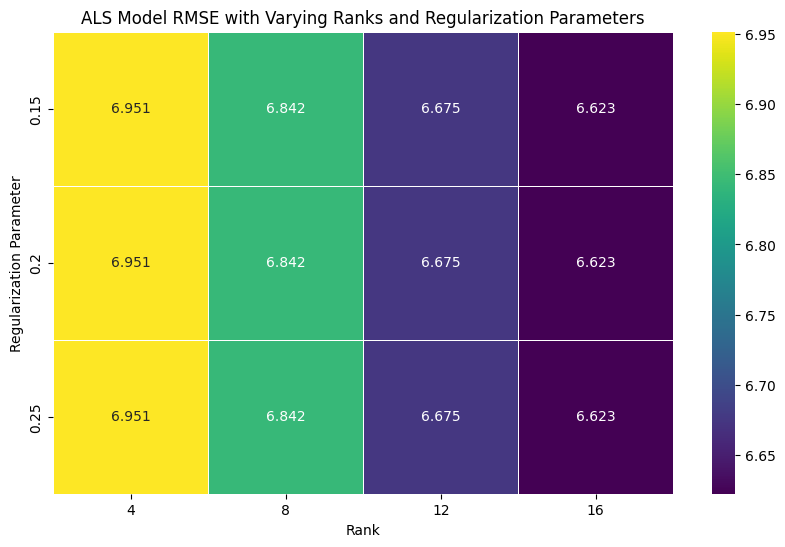

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'errors' is a 2D list of RMSE values
# rows correspond to different regularization parameters
# columns correspond to different ranks

# Convert errors to a numpy array for easier handling
error_matrix = np.array(errors)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(error_matrix, annot=True, fmt=".3f", linewidths=.5, cmap='viridis',
            xticklabels=ranks, yticklabels=regParams)

plt.title('ALS Model RMSE with Varying Ranks and Regularization Parameters')
plt.xlabel('Rank')
plt.ylabel('Regularization Parameter')
plt.show()


In [11]:
test_df = test_df.withColumn("Plays", test_df["Plays"].cast(DoubleType()))
predict_df = my_model.transform(test_df)

# Remove NaN values from prediction
predicted_test_df = predict_df.filter(predict_df.prediction != float('nan'))

# Round floats to whole numbers
predicted_test_df = predicted_test_df.withColumn("prediction", F.abs(F.round(predicted_test_df["prediction"],0)))
# Run the previously created RMSE evaluator, reg_eval, on the predicted_test_df DataFrame
test_RMSE = reg_eval.evaluate(predicted_test_df)

print('The model had a RMSE on the test set of {0}'.format(test_RMSE))

The model had a RMSE on the test set of 6.817601266330173


In [12]:
avg_plays_df = training_df.groupBy().avg('Plays').select(F.round('avg(Plays)'))

avg_plays_df.show(3)
# Extract the average rating value. (This is row 0, column 0.)
training_avg_plays = avg_plays_df.collect()[0][0]

print('The average number of plays in the dataset is {0}'.format(training_avg_plays))

# Add a column with the average rating
test_for_avg_df = test_df.withColumn('prediction', F.lit(training_avg_plays))

# Run the previously created RMSE evaluator, reg_eval, on the test_for_avg_df DataFrame
test_avg_RMSE = reg_eval.evaluate(test_for_avg_df)

print("The RMSE on the average set is {0}".format(test_avg_RMSE))

+--------------------+
|round(avg(Plays), 0)|
+--------------------+
|                 3.0|
+--------------------+

The average number of plays in the dataset is 3.0
The RMSE on the average set is 6.666914929507369


In [13]:
UserID = 17
listened_songs = raw_plays_df_with_int_ids.filter(raw_plays_df_with_int_ids.new_userId == UserID) \
                                          .join(metadata_df, 'songId') \
                                          .select('new_songId', 'artist_name', 'title') \
                                          
# generate list of listened songs
listened_songs_list = []
for song in listened_songs.collect():
    listened_songs_list.append(song['new_songId'])

print('Songs user has listened to:')
listened_songs.select('artist_name', 'title').show()

Songs user has listened to:


+---------------+-------+
|    artist_name|  title|
+---------------+-------+
|    OneRepublic|Secrets|
|Vampire Weekend|    Run|
|Vampire Weekend|Holiday|
+---------------+-------+



In [14]:
# generate dataframe of unlistened songs
unlistened_songs = raw_plays_df_with_int_ids.filter(~ raw_plays_df_with_int_ids['new_songId'].isin(listened_songs_list)) \
                                            .select('new_songId').withColumn('new_UserId', F.lit(UserID)).distinct()

unlistened_songs = unlistened_songs.withColumnRenamed('new_UserId', 'new_userId')

#unlistened_songs = unlistened_songs.filter(col("new_songId").cast("int").isNotNull())
unlistened_songs = unlistened_songs.withColumn("new_songId", col("new_songId").cast("integer"))
unlistened_songs = unlistened_songs.withColumn("new_userId", col("new_userId").cast("integer"))

# feed unlistened songs into model
predicted_listens = my_model.transform(unlistened_songs)


# remove NaNs
predicted_listens = predicted_listens.filter(predicted_listens['prediction'] != float('nan'))
predicted_listens.show(10)

predicted_listens = predicted_listens.withColumn("new_songId", col("new_songId").cast("integer"))
predicted_listens = predicted_listens.withColumn("new_userId", col("new_userId").cast("integer"))



+----------+----------+----------+
|new_songId|new_userId|prediction|
+----------+----------+----------+
|     39847|        17| 1.8039871|
|     32273|        17| 0.3882111|
|     19854|        17| 0.9243198|
|      5206|        17| 3.6683917|
|      2236|        17|0.21071935|
|     15398|        17|0.98601174|
|      5431|        17| 1.6802652|
|     10747|        17| 7.3067737|
|     14149|        17| 1.6429758|
|     14586|        17|  4.337965|
+----------+----------+----------+
only showing top 10 rows



In [18]:
# print output
print('Predicted Songs:')
predicted_listens.join(raw_plays_df_with_int_ids, 'new_songId') \
                 .join(metadata_df, 'songId') \
                 .select('artist_name', 'title', 'prediction') \
                 .distinct() \
                 .orderBy('prediction', ascending = False) \
                 .show(10,truncate=False)

Predicted Songs:


23/11/29 11:14:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+---------------+---------------------------------+----------+
|artist_name    |title                            |prediction|
+---------------+---------------------------------+----------+
|Van Halen      |Humans Being (Album Version)     |40.39946  |
|Scumbucket     |Call Me Anyone                   |29.412138 |
|The Ark        |Clamour For Glamour (Radio Edit) |27.924892 |
|Les Nubians    |Unfaithful / Si Infidèle         |21.477009 |
|Willie Gonzalez|No Podrás Escapar De Mi (En Vivo)|20.079897 |
|Young Jeezy    |Keep It Movin                    |20.077602 |
|Desmond Dekker |No Place Like Home               |19.63868  |
|Jay Reatard    |No Time                          |19.552528 |
|Super Cat      |Trash And Ready                  |19.505892 |
|Anthony Rother |Back Home                        |19.38985  |
+---------------+---------------------------------+----------+
only showing top 10 rows

